# Test problems 
## Belozerova Anastasia

In [1]:
import os
import imageio

In [2]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.autograd import Variable
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
crocks_path = "./samsung/crocodile/"
clocks_path = "./samsung/clock/"

In [5]:
crocks_pics = [pic for pic in os.listdir(crocks_path) if os.path.isfile(os.path.join(crocks_path, pic))]
clocks_pics = [pic for pic in os.listdir(clocks_path) if os.path.isfile(os.path.join(clocks_path, pic))]

In [6]:
print(len(crocks_pics), len(clocks_pics))

(500, 500)


Data is equal. Lets take a look at our examples

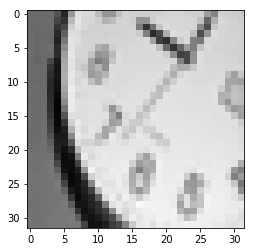

In [7]:
img = imageio.imread(clocks_path + clocks_pics[100])
plt.imshow(img.reshape(32, 32, 3))
plt.show()

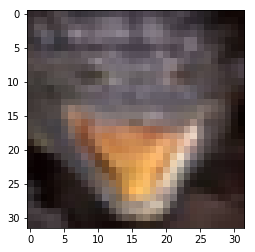

In [8]:
img = imageio.imread(crocks_path + crocks_pics[100])
plt.imshow(img.reshape(32, 32, 3))
plt.show()

Look rather different

Pictures are small, no augmentation is needed here. 
Lets prepare data for futher use

In [9]:
crocks = []
clocks = []

In [10]:
for pic in crocks_pics:
    crocks.append(imageio.imread(crocks_path + pic).reshape(3, 32, 32))
    
for pic in clocks_pics:
    clocks.append(imageio.imread(clocks_path + pic).reshape(3, 32, 32))
    
crocks = np.array(crocks)
clocks = np.array(clocks)

In [11]:
X = np.vstack([crocks, clocks])

Our task is binary classification. Lets say crocks are zeros and clocks are ones.

In [12]:
y_crocks = np.zeros(len(crocks))
y_clocks = np.ones(len(clocks))

Y = np.hstack([y_crocks, y_clocks])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 10)

Lets use sth easy for start. For example logistic regresssion. From that point of view every pixel of image is a feature. So we need to flatten them.

In [14]:
X_train_flat = np.array(list(map(lambda x: x.flatten(), X_train)))
X_test_flat = np.array(list(map(lambda x: x.flatten(), X_test)))

As logreg has several params such as penalty and C, lets use Greed Search to obtain best result

In [15]:
params = {"C": [1e-2, 1e-1, 1, 10], "penalty": ["l1", "l2"]}
model = LogisticRegression()
clf = GridSearchCV(model, params, scoring = "accuracy", cv = 10)

In [16]:
clf.fit(X_train_flat, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [17]:
print(accuracy_score(clf.predict(X_test_flat), y_test))

0.66


Result is really poor as we expected. Lets use some ddep learning.
Here I will use several blocks that were used in deep learning course. 

In [18]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [19]:
def build_model():
    model = nn.Sequential()
    
    model.add_module('conv1', nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3))
    model.add_module('mp1', nn.MaxPool2d(kernel_size = 2))
    model.add_module('relu1', nn.ReLU(inplace = True))
    model.add_module('drop1', nn.Dropout2d(p=0.1))

    model.add_module('conv2', nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 4))
    model.add_module('mp2', nn.MaxPool2d(kernel_size = 2))
    model.add_module('relu2', nn.ReLU(inplace = True))

    model.add_module('conv3', nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3))
    model.add_module('relu3', nn.ReLU(inplace = True))

    model.add_module('flat', Flatten())

    model.add_module('dense1', nn.Linear(in_features = 1024, out_features = 512))
    model.add_module('bn1', nn.BatchNorm1d(num_features = 512))
    model.add_module('relu4', nn.ReLU(inplace = True))

    model.add_module('dense2', nn.Linear(in_features = 512, out_features = 256))
    model.add_module('bn2', nn.BatchNorm1d(num_features = 256))
    model.add_module('relu5', nn.ReLU(inplace = True))

    model.add_module('dense3', nn.Linear(in_features = 256, out_features = 2))
    model.add_module('sm', nn.Softmax())

    return model

In [20]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [21]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.cuda.FloatTensor(X_batch))
    y_batch = Variable(torch.cuda.LongTensor(y_batch))
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [22]:
batch_size = 50
n_epoch = 15

In [23]:
model = build_model()
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [24]:
model.cuda()

loss_array = []
train_accuracy = []
test_accuracy = []

for i in range(n_epoch):
    print("epoch #%i" % (i + 1))
    model.train(True)
    
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_array.append(loss.cpu().data.numpy()[0])
        
    print("loss = %.2f" % loss)
        
    model.train(False)
    
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        logits = model(Variable(torch.cuda.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        train_accuracy.append(np.mean(y_batch == y_pred))
        
    print("train accuracy = %.2f" % train_accuracy[-1])
    
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size):
        logits = model(Variable(torch.cuda.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        test_accuracy.append(np.mean(y_batch == y_pred))
        
    print("test accuracy = %.2f" % test_accuracy[-1])

epoch #1


/usr/local/lib/python2.7/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss = 0.58
train accuracy = 0.62
test accuracy = 0.70
epoch #2
loss = 0.51
train accuracy = 0.88
test accuracy = 0.82
epoch #3
loss = 0.46
train accuracy = 0.88
test accuracy = 0.90
epoch #4
loss = 0.45
train accuracy = 0.76
test accuracy = 0.70
epoch #5
loss = 0.45
train accuracy = 0.78
test accuracy = 0.82
epoch #6
loss = 0.44
train accuracy = 0.86
test accuracy = 0.90
epoch #7
loss = 0.45
train accuracy = 0.80
test accuracy = 0.76
epoch #8
loss = 0.39
train accuracy = 0.88
test accuracy = 0.84
epoch #9
loss = 0.57
train accuracy = 0.94
test accuracy = 0.86
epoch #10
loss = 0.45
train accuracy = 0.82
test accuracy = 0.84
epoch #11
loss = 0.43
train accuracy = 0.80
test accuracy = 0.78
epoch #12
loss = 0.46
train accuracy = 0.96
test accuracy = 0.90
epoch #13
loss = 0.40
train accuracy = 0.92
test accuracy = 0.86
epoch #14
loss = 0.42
train accuracy = 0.92
test accuracy = 0.86
epoch #15
loss = 0.40
train accuracy = 0.98
test accuracy = 0.82


Score is much better than in logreg case!
Results seem rather stochastic. Lets plot them

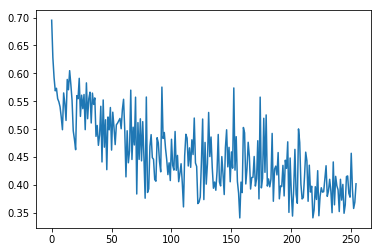

In [25]:
plt.plot(loss_array)
plt.show()

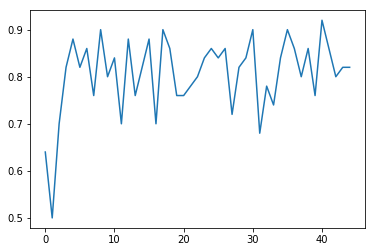

In [26]:
plt.plot(test_accuracy)
plt.show()

Our net needs more regularization. So more dropouts and batch normalizations are needed

In [27]:
def build_model():
    model = nn.Sequential()
    
    model.add_module('conv1', nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3))
    model.add_module('bn1', nn.BatchNorm2d(16))
    model.add_module('relu1', nn.ReLU(inplace = True))
    model.add_module('drop1', nn.Dropout2d(p=0.1))

    model.add_module('conv2', nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3))
    model.add_module('bn2', nn.BatchNorm2d(32))
    model.add_module('mp2', nn.MaxPool2d(kernel_size = 2))
    model.add_module('relu2', nn.ReLU(inplace = True))
    model.add_module('drop2', nn.Dropout2d(p=0.1))

    model.add_module('conv3', nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3))
    model.add_module('bn3', nn.BatchNorm2d(64))
    model.add_module('relu3', nn.ReLU(inplace = True))
    
    model.add_module('conv4', nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 3))
    model.add_module('bn4', nn.BatchNorm2d(256))
    model.add_module('mp4', nn.MaxPool2d(kernel_size = 2))
    model.add_module('relu4', nn.ReLU())

    model.add_module('flat', Flatten())

    model.add_module('dense1', nn.Linear(in_features = 6400, out_features = 512))
    model.add_module('bn5', nn.BatchNorm1d(num_features = 512))
    model.add_module('relu5', nn.ReLU(inplace = True))

    model.add_module('dense2', nn.Linear(in_features = 512, out_features = 128))
    model.add_module('bn6', nn.BatchNorm1d(num_features = 128))
    model.add_module('relu6', nn.ReLU(inplace = True))

    model.add_module('dense3', nn.Linear(in_features = 128, out_features = 2))
    model.add_module('sm', nn.Softmax())

    return model

In [28]:
batch_size = 15
n_epoch = 40

model = build_model()
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [29]:
model.cuda()

loss_array = []
train_accuracy = []
test_accuracy = []

for i in range(n_epoch):
    print("epoch #%i" % (i + 1))
    model.train(True)
    
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_array.append(loss.cpu().data.numpy()[0])
        
    print("loss = %.2f" % loss)
        
    model.train(False)
    
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        logits = model(Variable(torch.cuda.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        train_accuracy.append(np.mean(y_batch == y_pred))
        
    print("train accuracy = %.2f" % train_accuracy[-1])
    
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size):
        logits = model(Variable(torch.cuda.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        test_accuracy.append(np.mean(y_batch == y_pred))
        
    print("test accuracy = %.2f" % test_accuracy[-1])

epoch #1
loss = 0.45
train accuracy = 0.70
test accuracy = 0.73
epoch #2
loss = 0.57
train accuracy = 0.60
test accuracy = 0.73
epoch #3
loss = 0.48
train accuracy = 0.90
test accuracy = 0.73
epoch #4
loss = 0.33
train accuracy = 0.80
test accuracy = 0.60
epoch #5
loss = 0.53
train accuracy = 0.70
test accuracy = 0.67
epoch #6
loss = 0.75
train accuracy = 0.60
test accuracy = 0.73
epoch #7
loss = 0.56
train accuracy = 1.00
test accuracy = 0.87
epoch #8
loss = 0.50
train accuracy = 0.70
test accuracy = 0.87
epoch #9
loss = 0.60
train accuracy = 0.80
test accuracy = 0.53
epoch #10
loss = 0.61
train accuracy = 1.00
test accuracy = 0.80
epoch #11
loss = 0.64
train accuracy = 0.90
test accuracy = 0.87
epoch #12
loss = 0.43
train accuracy = 0.90
test accuracy = 0.80
epoch #13
loss = 0.46
train accuracy = 0.90
test accuracy = 0.87
epoch #14
loss = 0.39
train accuracy = 0.80
test accuracy = 0.80
epoch #15
loss = 0.57
train accuracy = 0.90
test accuracy = 0.80
epoch #16
loss = 0.35
train accura

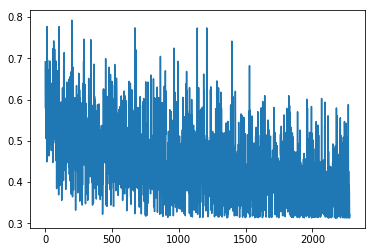

In [30]:
plt.plot(loss_array)
plt.show()

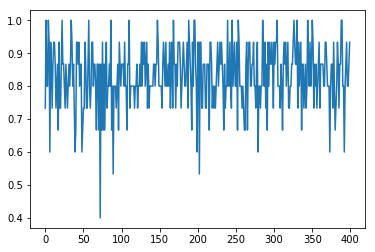

In [31]:
plt.plot(test_accuracy)
plt.show()

In [32]:
test_accuracy[-1]

0.93333333333333335

This score is impressive enough.

Now lets take a look at pics that are similar to both crocks and clocks. At this pictures our classifier is least confident. 

At y_pred we can see probabilities for both classes that predict classifier. 

At difficult pictures it should be close to $0.5$ - from $0.45$ to $0.55$ for example

In [33]:
suspects = []
class_pred = []

for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
    logits = model(Variable(torch.cuda.FloatTensor(X_batch)))
    y_pred = logits.max(1)[0].cpu().data.numpy()
    indexes = np.array(np.where(np.abs(y_pred - 0.5) <= 0.05))[0]
    
    if len(indexes) > 0:
        for i in range(len(indexes)):
            class_pred.append(logits.max(1)[1].cpu().data.numpy()[indexes[i]])
            suspects.append(X_batch[indexes[i]])

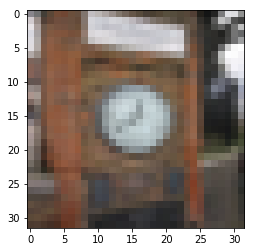

Was classified wrongly


In [34]:
plt.imshow(suspects[0].reshape(32, 32, 3))
plt.show()
if class_pred[0]:
    print("Was classified well")
else:
    print("Was classified wrongly")

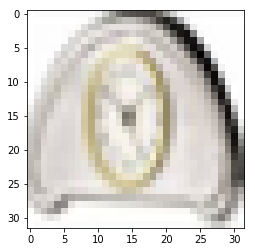

Was classified wrongly


In [37]:
plt.imshow(suspects[1].reshape(32, 32, 3))
plt.show()
if class_pred[1]:
    print("Was classified well")
else:
    print("Was classified wrongly")

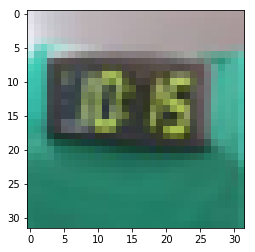

Was classified wrongly


In [36]:
plt.imshow(suspects[2].reshape(32, 32, 3))
plt.show()
if class_pred[2]:
    print("Was classified well")
else:
    print("Was classified wrongly")

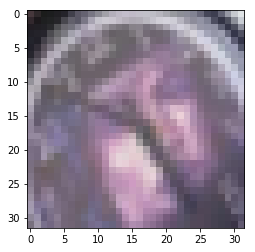

Was classified wrongly


In [42]:
plt.imshow(suspects[3].reshape(32, 32, 3))
plt.show()
if class_pred[2]:
    print("Was classified well")
else:
    print("Was classified wrongly")

As for me they all obvious to classify - no similarity is seen. But I am not machine.